# Mistral Instruct 7B Starter - CV 0.7X - LB 0.7X
Hi everyone. I'm learning to finetune large decoder language models like Mistral 7B. 

This Kaggle competition is a perfect opportunity to explore finetuning LLM like `mistralai/Mistral-7B-Instruct-v0.2` [here][1]. Nowadays, large LLM (like Mistral, Llama, Claude, Gemini, Vicuna, etc) are popular and I'm curious to see how they compare to "smaller" models like DeBERTa on basic tasks like classification and regression! 

The following notebook finetunes `Mistral Instruct 7B` to predict the essay score in Kaggle's essay comp. This code is most likely **not** the best way of doing everything because i'm just learning. We have much opportunity to improve this notebook! Let's discuss ways to improve this notebook in the comments!

### Notes:
I use HuggingFace `Trainer` to train Mistral instead of `SFTTrainer`. Note that SFTTrainer has more conveinent features to make our life easier like assisting us in PEFT and dataloading. Furthermore, I load and train Mistral in `fp16` because we have enough memory to do so on Kaggle 2xT4. Perhaps using `4bit` quantization will speed up training but it could effect accuracy. Certainly if we want to try larger LLM, we should use `4bit` quantization.

I only train with 3072 rows of train data for 1 epoch for speed, but training with more train data will certainly improve our CV score and LB score. We can improve the PEFT parameters and LR schedule for better performance too.

We can use tricks (to help with training) like `gradient accumulation` and `gradient checkpointing` but i do not in this notebook.

When I try to train on 2xT4 in Kaggle notebook, I get an error. I'm not sure why :( So, this notebook loads a model that I trained locally on 2xV100 GPU (using this notebook).

Enjoy!

[1]: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2

# Load Data and Model
We load `Mistral-7B-Instruct-v0.2` in `fp16` unto both 2xT4 Kaggle GPU. I change tokenizer padding to right because it makes more sense to me. However it might not be best way. And I update the pad token.

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

VER=1
# USE FIRST K ROWS FOR VALIDATION
VAL_SET = 1024
# MAX SEQ LENGTH FOR MISTRAL TRAINING
MAX_LEN = 1024
# BATCH SIZE PER DEVICE
BATCH_SIZE = 1 
# NUMBER OF EPOCHS
EPOCHS = 1
# USE NEXT K ROWS FOR TRAIN
TRAIN_SET = 3072
# IF LOAD PATH IS NOT NONE, WE LOAD INSTEAD OF TRAIN
LOAD_PATH = '/kaggle/input/mistral-v0/'

In [2]:
import pandas as pd, numpy as np
df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
print('Train shape:', df.shape )
df.head()

Train shape: (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

#model_name = 'mistralai/Mistral-7B-Instruct-v0.2' # WHEN INTERNET IS TURNED ON
model_name = '/kaggle/input/mistral-7b-instruct-v02-fp16'
model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='right') 
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Data Loader
We create a data loader using HuggingFace's Dataset. We could also make a dataloader with PyTorch's Dataset. Both are equally useful. We use the Mistral Instruct template to train and infer our model. It is shown below.

In [4]:
from datasets import Dataset
dataset_v = Dataset.from_pandas(df.iloc[:VAL_SET])
dataset_t = Dataset.from_pandas(df.iloc[VAL_SET:VAL_SET+TRAIN_SET])

In [5]:
def preprocess(sample, text=False, infer_mode=False, max_seq=MAX_LEN, return_tensors=None):
    
    sys_prompt = "Please read the following essay and assign a score of 1,2,3,4,5,6 where 6 is the best. Output only a single number with no explanation.\n\n"
    prompt = sample["full_text"]
    if infer_mode: answer = ""
    else: answer = str(sample["score"])
        
    messages = [
        {"role": "user", "content": sys_prompt + prompt},
        {"role": "assistant", "content": f"\n\nThe score is: " + answer}
    ]
    formatted_sample = tokenizer.apply_chat_template(messages, tokenize=False)
    if infer_mode: formatted_sample = formatted_sample.replace("</s>","")
        
    tokenized_sample = tokenizer(formatted_sample, padding=True, return_tensors=return_tensors, 
                                 truncation=True, add_special_tokens=False, max_length=max_seq) 
    
    if return_tensors=="pt":
        tokenized_sample["labels"] = tokenized_sample["input_ids"].clone()
    else:
        tokenized_sample["labels"] = tokenized_sample["input_ids"].copy()
    
    if text: return formatted_sample
    else: return tokenized_sample

In [6]:
print( preprocess(df.iloc[0], text=True) )

<s>[INST] Please read the following essay and assign a score of 1,2,3,4,5,6 where 6 is the best. Output only a single number with no explanation.

Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely "car free" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a h

In [7]:
tokenized_dataset_v = dataset_v.map(preprocess, num_proc=4, 
                            remove_columns=['essay_id', 'full_text', 'score'])
tokenized_dataset_t = dataset_t.map(preprocess, num_proc=4, 
                            remove_columns=['essay_id', 'full_text', 'score'])

Map (num_proc=4):   0%|          | 0/1024 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3072 [00:00<?, ? examples/s]

# Train Mistral Instruct
We train with HuggingFace `Trainer`. For more conveinence, we could use HuggingFace new `SFTTrainer` but i'm ok with more manual steps. We use PEFT for more efficient training. Note that I have **not** found the best hyperparameters for PEFT.

We use `DataCollatorForSeq2Seq`. This doesn't make a difference if we use `BATCH_SIZE = 1`, but if we train offline with `BATCH_SIZE > 1` this will speed up training. For each batch, it will keep the sequence length as short as possible. It will add padding so that both samples have length equal to the larger of the two samples. This is faster than padding every sample in train dataset to a maximum 1024.

In [8]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    logging_dir = f'./logs_v{VER}',
    output_dir = f'./output_v{VER}',
    logging_steps=125,
    save_steps=250,
    logging_first_step=True,
    fp16=True,
    overwrite_output_dir=True,
    warmup_ratio=0.0,
    learning_rate=5e-5,
    lr_scheduler_type='constant',
    weight_decay=0.01,
    eval_steps=None,
    evaluation_strategy='no',
    save_total_limit=2,
    report_to='none',
)

2024-04-20 01:58:34.822334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 01:58:34.822443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 01:58:34.973333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
!pip install /kaggle/input/llm-peft-pkg/peft-0.10.0-py3-none-any.whl

Processing /kaggle/input/llm-peft-pkg/peft-0.10.0-py3-none-any.whl


In [10]:
from peft import LoraConfig, get_peft_model
peft_config = LoraConfig(
    lora_alpha=16, # regularization
    lora_dropout=0.1, 
    r=32, # attention heads
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj"], 
)
if not LOAD_PATH:
    model = get_peft_model(model, peft_config)

In [11]:
from transformers import DataCollatorForSeq2Seq
collator = DataCollatorForSeq2Seq(tokenizer, padding='longest')

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_t,
    eval_dataset=tokenized_dataset_v,
    data_collator=collator,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [13]:
from peft import PeftModel

if not LOAD_PATH:
    trainer.train()
    model.save_pretrained(f"mistral_v{VER}")
else:
    model = PeftModel.from_pretrained(model, LOAD_PATH)

# Validation Score
We trained with `MAX_LEN = 1024` but we can infer with any size. We infer with `size 2048` for the 3% of texts that are longer than 1024.

In [14]:
%%time

import warnings
warnings.filterwarnings('ignore')
preds = []

for i,row in df.iloc[:VAL_SET].iterrows():

    if i%100==0: print(i,', ',end='')
        
    tokenized_sample = preprocess(row, infer_mode=True, max_seq=2048, return_tensors="pt")
    generated_ids = model.generate(**tokenized_sample, 
                                    max_new_tokens=1,
                                    pad_token_id=tokenizer.eos_token_id,
                                    do_sample=False)
    decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    
    try:
        answer = decoded[0].rsplit("The score is: ", 1)[1]
        preds.append( int(answer) )
    except:
        preds.append( 3 )
        
    if i==7: print(f'preds[:8]={preds}, ',end='')

0 , preds[:8]=[1, 3, 4, 4, 2, 4, 2, 3], 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , CPU times: user 6min 18s, sys: 1min 9s, total: 7min 28s
Wall time: 7min 28s


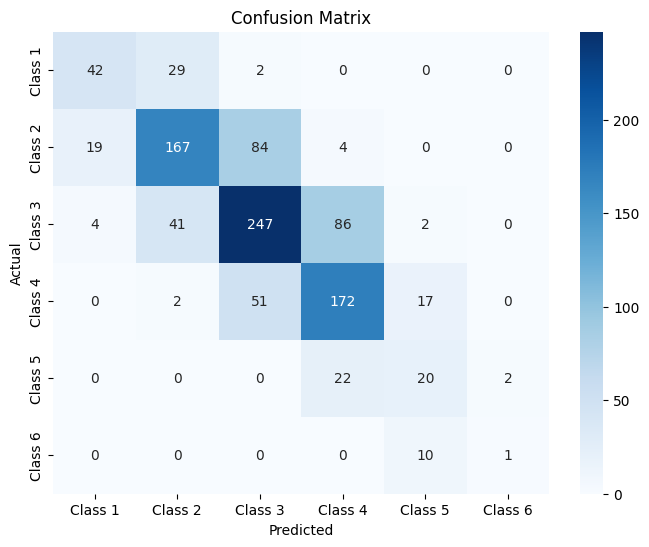

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(df.score.values[:VAL_SET], preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Class {i}" for i in range(1,7)], 
            yticklabels=[f"Class {i}" for i in range(1,7)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(df.score.values[:VAL_SET], preds, weights="quadratic")
print(f'Validation QWK Score = {qwk}')

Validation QWK Score = 0.800616722480487


# Infer Test Data

In [17]:
test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [18]:
test_preds = []

for i,row in test.iterrows():

    tokenized_sample = preprocess(row, infer_mode=True, max_seq=2048, return_tensors="pt")
    generated_ids = model.generate(**tokenized_sample, 
                                    max_new_tokens=1,
                                    pad_token_id=tokenizer.eos_token_id,
                                    do_sample=False)
    decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    
    try:
        answer = decoded[0].rsplit("The score is: ", 1)[1]
        test_preds.append( int(answer) )
    except:
        test_preds.append( 3 )
        
    if i==2: print(f'test_preds[:3]={test_preds}, ',end='')

test_preds[:3]=[1, 3, 4], 

In [19]:
sub = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv')
print('Sub shape',sub.shape)
sub.head()

Sub shape (3, 2)


,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [20]:
sub.score = test_preds
sub.score = sub.score.astype('int') # JUST TO BE SAFE
sub.to_csv('submission.csv',index=False)
sub.head()

,essay_id,score
0,000d118,1
1,000fe60,3
2,001ab80,4
